In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_00141_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.132470396811132802311388148633431047614-1.3.6.1.4.1.9590.100.1.2.319647729912087119402966470430252610901-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01773_RIGHT_CC_1-1.3.6.1.4.1.9590.100.1.2.251873479111874220326365927782688038525-1.3.6.1.4.1.9590.100.1.2.411332629211742096700949712693333832845-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01882_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.256905759811225865232082510450884767166-1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01058_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.280045004412750688539985071920278671695-1.3.6.1.4.1.9590.100.1.2.4181

In [3]:
import sys
import pickle
import itertools
import re

import tensorflow as tf

from tensorflow import keras
from keras import models, optimizers, regularizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import plot_model, to_categorical


# path manipulation
from pathlib import Path

# image manipulation
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [4]:
cbis_path = '/kaggle/input/cbis-ddsmpatched/CBIS_DDSM'

In [5]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

### The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'
4.   Convert the labels to categorical format, required by the categorical_crossentropy loss function
5.   Normalize the pixels to be in the range (0-1) floating point
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets ****
8.   Build Keras generators for training and validation data. 

### Reference for the repository of CBIS-DDSM:
*    Title: MedicalCNN
*    Author: Lai, Leonardo
*    Date: 04/2021
*    Version: 1.0
*    Availability: https://github.com/leoll2/MedicalCNN.git

In [6]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
#     width_shift_range=0.1,      
#     height_shift_range=0.1,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
val_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


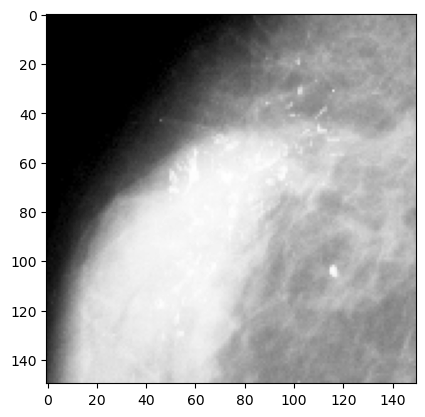

Label: [0. 0. 0. 1.]


In [6]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct
import random

# print(random.randint(0,2675))
idx = random.randint(0,2675)

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

## Trial 0

In [7]:
model_0 = Sequential()
model_0.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_0.add(MaxPool2D(pool_size=2, strides=2))
model_0.add(Conv2D(64, kernel_size = (3, 3) ,activation='relu'))
model_0.add(MaxPool2D(pool_size=2, strides=2))
model_0.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model_0.add(MaxPool2D(pool_size=2, strides=2))
model_0.add(Dropout(0.25))
model_0.add(Flatten()) 
model_0.add(Dense(64, activation='relu'))
model_0.add(Dropout(0.25))
model_0.add(Dense(4, activation='softmax'))
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
# set optmizer and learning rate
adam = Adam(0.001)

model_0.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'best_model_0_4cl.h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_0 = model_0.fit(train_gen, validation_data=val_gen, epochs=500,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/500


2023-04-20 20:59:19.431438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 [==============================] - ETA: 0s - loss: 1.4569 - accuracy: 0.2947
Epoch 1: val_loss improved from inf to 1.36925, saving model to best_model_0_4cl.h5
17/17 [==============================] - 20s 395ms/step - loss: 1.4569 - accuracy: 0.2947 - val_loss: 1.3692 - val_accuracy: 0.3439
Epoch 2/500
17/17 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.3578
Epoch 2: val_loss improved from 1.36925 to 1.34748, saving model to best_model_0_4cl.h5
17/17 [==============================] - 5s 311ms/step - loss: 1.3576 - accuracy: 0.3578 - val_loss: 1.3475 - val_accuracy: 0.3439
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.3582
Epoch 3: val_loss improved from 1.34748 to 1.33915, saving model to best_model_0_4cl.h5
17/17 [==============================] - 5s 304ms/step - loss: 1.3458 - accuracy: 0.3582 - val_loss: 1.3391 - val_accuracy: 0.3720
Epoch 4/500
17/17 [==============================] - ETA: 0s - loss: 1.33

In [10]:
models.save_model(model_0, 'model_0_4cl.h5')

In [44]:
# # History of accuracy and loss
# tra_loss = hist.history['loss']
# tra_acc = hist.history['accuracy']
# val_loss = hist.history['val_loss']
# val_acc = hist.history['val_accuracy']

# # Total number of epochs training
# epochs = range(1, len(tra_acc)+1)
# end_epoch = len(tra_acc)

# # Epoch when reached the validation loss minimum
# opt_epoch = val_loss.index(min(val_loss)) + 1

# # Loss and accuracy on the validation set
# end_val_loss = val_loss[-1]
# end_val_acc = val_acc[-1]
# opt_val_loss = val_loss[opt_epoch-1]
# opt_val_acc = val_acc[opt_epoch-1]

# # Loss and accuracy on the test set
# opt_model = model
# test_loss, test_acc = model_0.evaluate(test_images, test_labels, verbose=False)
# opt_test_loss, opt_test_acc = opt_model.evaluate(test_images, test_labels, verbose=False)

# print("Model Result\n")
# print("Epoch [end]: %d" % end_epoch)
# print("Epoch [opt]: %d\n" % opt_epoch)
# print("Valid accuracy [end]: %.4f" % end_val_acc)
# print("Valid accuracy [opt]: %.4f" % opt_val_acc)
# print("Test accuracy [end]:  %.4f" % test_acc)
# print("Test accuracy [opt]:  %.4f\n" % opt_test_acc)
# print("Valid loss [end]: %.4f" % end_val_loss)
# print("Valid loss [opt]: %.4f" % opt_val_loss)
# print("Test loss [end]:  %.4f" % test_loss)
# print("Test loss [opt]:  %.4f" % opt_test_loss)

In [11]:
# History of accuracy and loss
tra_loss_0 = hist_0.history['loss']
tra_acc_0 = hist_0.history['accuracy']
val_loss_0 = hist_0.history['val_loss']
val_acc_0 = hist_0.history['val_accuracy']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('best_model_0_4cl.h5')
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)
opt_pred_0 = opt_model_0.predict(test_images)
pred_classes_0 = np.rint(opt_pred_0)

print("Model 0\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d\n" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_0)

print(classification_report(test_labels, pred_classes_0, digits=4))

11/11 [==============================] - 0s 6ms/step
Model 0

Epoch [end]: 189
Epoch [opt]: 139

Valid accuracy [end]: 0.6449
Valid accuracy [opt]: 0.6355
Test accuracy [end]:  0.5685
Test accuracy [opt]:  0.5685

Valid loss [end]: 0.8148
Valid loss [opt]: 0.7932
Test loss [end]:  0.9581
Test loss [opt]:  0.9581

              precision    recall  f1-score   support

           0     0.7170    0.3363    0.4578       113
           1     0.5476    0.3485    0.4259        66
           2     0.7326    0.5943    0.6562       106
           3     0.5625    0.1765    0.2687        51

   micro avg     0.6751    0.3958    0.4991       336
   macro avg     0.6399    0.3639    0.4522       336
weighted avg     0.6652    0.3958    0.4854       336
 samples avg     0.3958    0.3958    0.3958       336



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


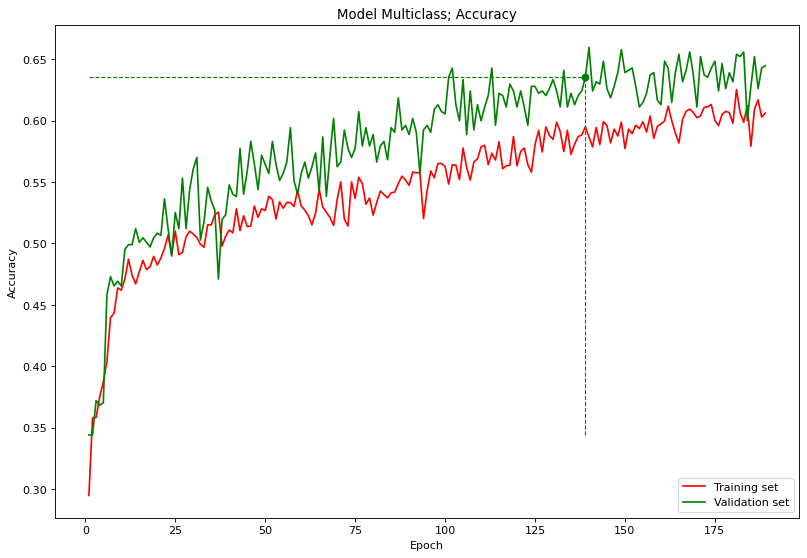

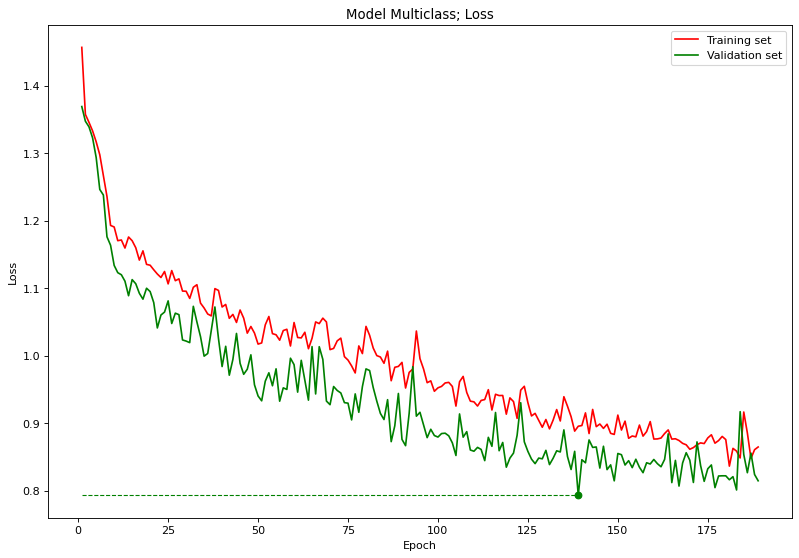

In [12]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
# plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();
# plt.savefig('Model0Loss_figure.png')

## Trial 1

### The model seem to be learning the data, although the validation performance together with the accuracy is not good enough. The val loss starts to be unstable at 300 epochs onwards, for this reasons a more complex model will be tested, and if necessary regularizations techniques will be integrated to control the variance.

In [13]:
model_1 = Sequential()
model_1.add(Conv2D(64, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Conv2D(128, kernel_size = (3, 3) ,activation='relu'))
model_1.add(MaxPool2D(pool_size=2, strides=2))
model_1.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=2, strides=2))
# model_1.add(Conv2D(512, kernel_size = (3, 3), activation='relu'))
# model_1.add(MaxPool2D(pool_size=2, strides=2))
# model_1.add(Dropout(0.25))
model_1.add(Flatten()) 
# model_1.add(Dense(128, activation='relu', activity_regularizer = regularizers.l2(1e-5)))
# model_1.add(Dropout(0.25))
model_1.add(Dense(64, activation='relu', activity_regularizer = regularizers.l2(1e-5)))
model_1.add(Dropout(0.25))
model_1.add(Dense(4, activation='softmax'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 256)     

In [14]:
# set optmizer and learning rate
adam = Adam(0.001)

model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'best_model_1_4cl.h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_1 = model_1.fit(train_gen, validation_data=val_gen, epochs=500,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/500
17/17 [==============================] - ETA: 0s - loss: 1.4141 - accuracy: 0.3213
Epoch 1: val_loss improved from inf to 1.36338, saving model to best_model_1_4cl.h5
17/17 [==============================] - 13s 537ms/step - loss: 1.4141 - accuracy: 0.3213 - val_loss: 1.3634 - val_accuracy: 0.3439
Epoch 2/500
17/17 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.3638
Epoch 2: val_loss improved from 1.36338 to 1.34002, saving model to best_model_1_4cl.h5
17/17 [==============================] - 6s 354ms/step - loss: 1.3496 - accuracy: 0.3638 - val_loss: 1.3400 - val_accuracy: 0.3495
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.3704
Epoch 3: val_loss improved from 1.34002 to 1.32686, saving model to best_model_1_4cl.h5
17/17 [==============================] - 6s 333ms/step - loss: 1.3335 - accuracy: 0.3704 - val_loss: 1.3269 - val_accuracy: 0.3570
Epoch 4/500
17/17 [==============================] - ETA: 0s 

In [15]:
models.save_model(model_1, 'model_1_4cl.h5')

In [16]:
# History of accuracy and loss
tra_loss_1 = hist_1.history['loss']
tra_acc_1 = hist_1.history['accuracy']
val_loss_1 = hist_1.history['val_loss']
val_acc_1 = hist_1.history['val_accuracy']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('best_model_1_4cl.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict(test_images)
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d\n" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

11/11 [==============================] - 0s 11ms/step
Model 1

Epoch [end]: 272
Epoch [opt]: 222

Valid accuracy [end]: 0.6692
Valid accuracy [opt]: 0.6598
Test accuracy [end]:  0.5565
Test accuracy [opt]:  0.5565

Valid loss [end]: 0.8002
Valid loss [opt]: 0.7888
Test loss [end]:  1.0047
Test loss [opt]:  1.0047

              precision    recall  f1-score   support

           0     0.7143    0.3540    0.4734       113
           1     0.5306    0.3939    0.4522        66
           2     0.6699    0.6509    0.6603       106
           3     0.5385    0.1373    0.2188        51

   micro avg     0.6425    0.4226    0.5099       336
   macro avg     0.6133    0.3840    0.4511       336
weighted avg     0.6375    0.4226    0.4895       336
 samples avg     0.4226    0.4226    0.4226       336



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


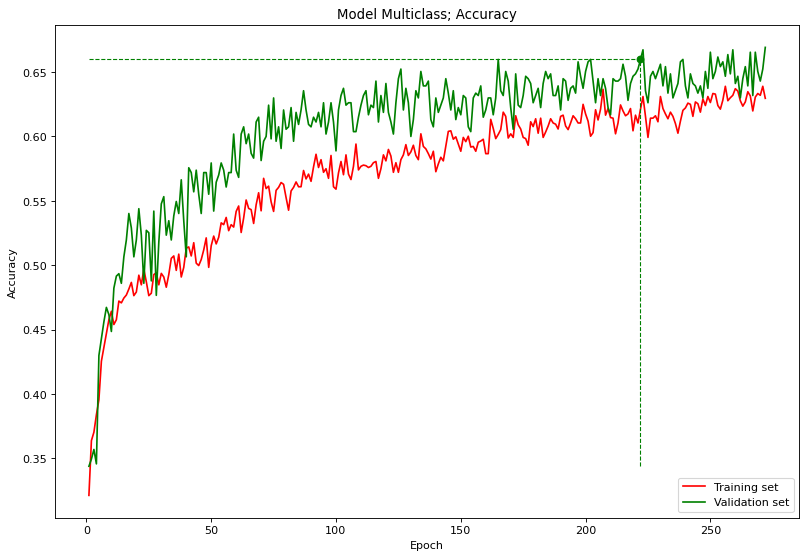

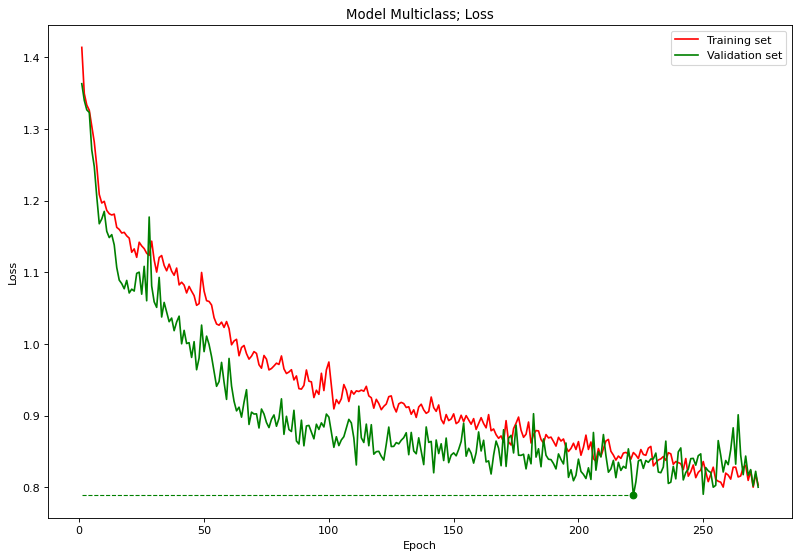

In [17]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
# plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();
# plt.savefig('Model0Loss_figure.png')

## Trial 2

In [18]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size = (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(128, kernel_size = (3, 3) ,activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(192, kernel_size = (3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Conv2D(256, kernel_size = (3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=2, strides=2))
model_2.add(Dropout(0.25))
model_2.add(Flatten()) 
model_2.add(Dense(64, activation='relu', activity_regularizer = regularizers.l2(1e-5)))
model_2.add(Dropout(0.25))
model_2.add(Dense(4, activation='softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 192)       221376    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 192)     

In [19]:
# set optmizer and learning rate
adam = Adam(0.001)

model_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'best_model_2_4cl.h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')

# Train the model
hist_2 = model_2.fit(train_gen, validation_data=val_gen, epochs=500,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/500


2023-04-20 21:54:21.469879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 [==============================] - ETA: 0s - loss: 1.3766 - accuracy: 0.3284
Epoch 1: val_loss improved from inf to 1.37006, saving model to best_model_2_4cl.h5
17/17 [==============================] - 10s 452ms/step - loss: 1.3766 - accuracy: 0.3284 - val_loss: 1.3701 - val_accuracy: 0.3439
Epoch 2/500
17/17 [==============================] - ETA: 0s - loss: 1.3667 - accuracy: 0.3568
Epoch 2: val_loss improved from 1.37006 to 1.36056, saving model to best_model_2_4cl.h5
17/17 [==============================] - 6s 353ms/step - loss: 1.3667 - accuracy: 0.3568 - val_loss: 1.3606 - val_accuracy: 0.3439
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.3568
Epoch 3: val_loss improved from 1.36056 to 1.35005, saving model to best_model_2_4cl.h5
17/17 [==============================] - 6s 354ms/step - loss: 1.3608 - accuracy: 0.3568 - val_loss: 1.3501 - val_accuracy: 0.3439
Epoch 4/500
17/17 [==============================] - ETA: 0s - loss: 1.35

In [21]:
models.save_model(model_2, 'model_2_4cl.h5')

In [23]:
# History of accuracy and loss
tra_loss_2 = hist_2.history['loss']
tra_acc_2 = hist_2.history['accuracy']
val_loss_2 = hist_2.history['val_loss']
val_acc_2 = hist_2.history['val_accuracy']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('best_model_2_4cl.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict(test_images)
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d\n" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

11/11 [==============================] - 0s 11ms/step
Model 2

Epoch [end]: 327
Epoch [opt]: 277

Valid accuracy [end]: 0.6467
Valid accuracy [opt]: 0.6467
Test accuracy [end]:  0.5833
Test accuracy [opt]:  0.5833

Valid loss [end]: 0.8082
Valid loss [opt]: 0.7755
Test loss [end]:  0.9864
Test loss [opt]:  0.9864

              precision    recall  f1-score   support

           0     0.7042    0.4425    0.5435       113
           1     0.5476    0.3485    0.4259        66
           2     0.7021    0.6226    0.6600       106
           3     0.7692    0.1961    0.3125        51

   micro avg     0.6773    0.4435    0.5360       336
   macro avg     0.6808    0.4024    0.4855       336
weighted avg     0.6827    0.4435    0.5221       336
 samples avg     0.4435    0.4435    0.4435       336



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


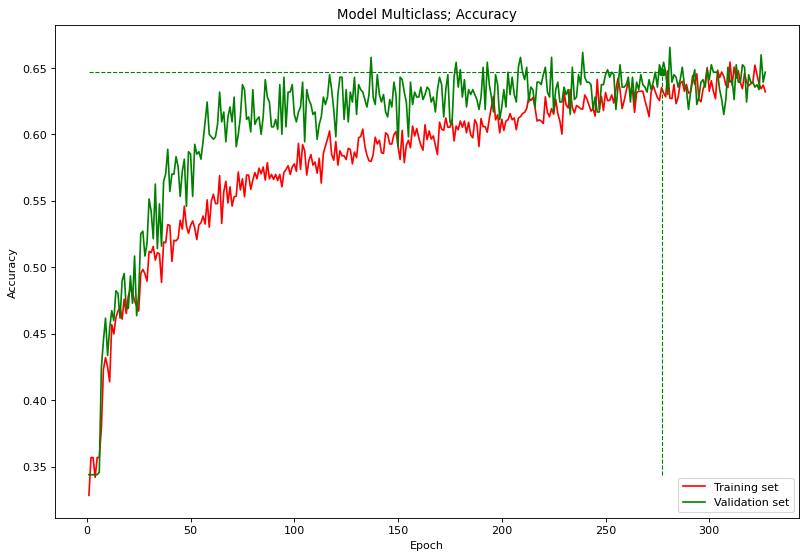

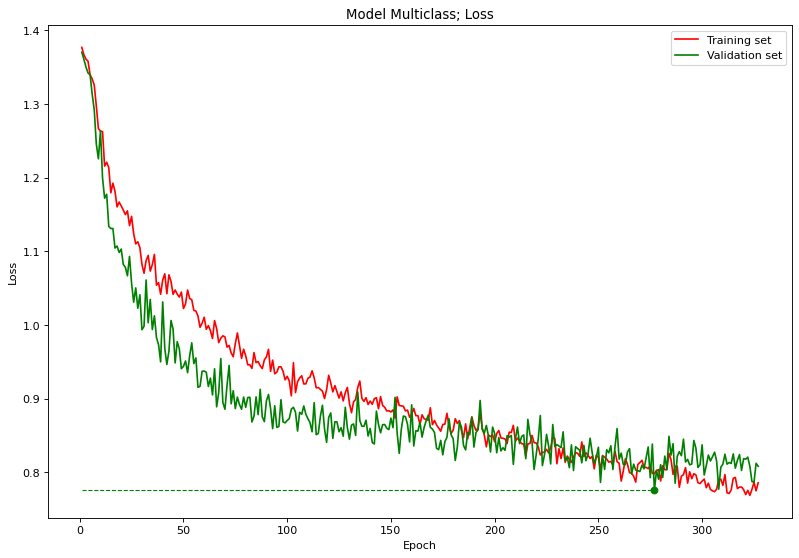

In [24]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
# plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();
# plt.savefig('Model0Loss_figure.png')

In [25]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Experiment of RESULTS


In [41]:
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_0 = models.load_model('best_model_0_4cl.h5')
opt_model_1 = models.load_model('best_model_1_4cl.h5')
opt_model_2 = models.load_model('best_model_2_4cl.h5')


pred_0 = opt_model_0.predict(test_images)
pred_1 = opt_model_1.predict(test_images)
pred_2 = opt_model_0.predict(test_images)


# errors_0, mispred_0, hard_mispred_0 = get_errors(pred_0)
# errors_1, mispred_1, hard_mispred_1 = get_errors(pred_1)
# errors_2, mispred_2, hard_mispred_2 = get_errors(pred_2)

11/11 [==============================] - 0s 6ms/step


11/11 [==============================] - 0s 7ms/step


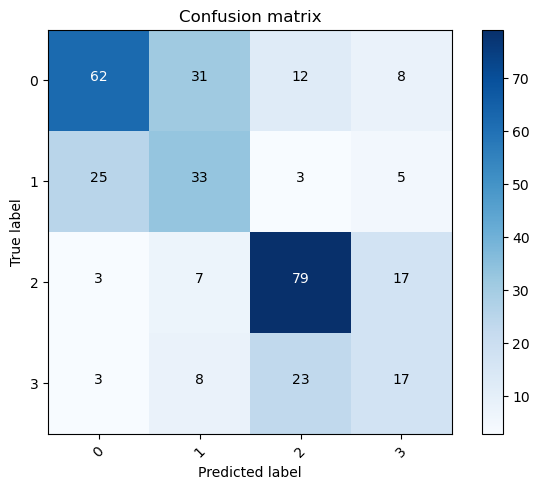

In [29]:
pred_0_classes = np.argmax(opt_model_0.predict(test_images), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_0_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Confusion matrix')
# plot_confusion_matrix.savefig('ConfusionMatrix.png')

11/11 [==============================] - 0s 13ms/step


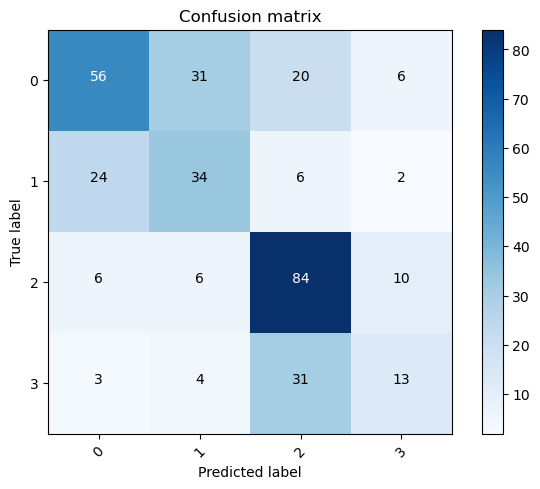

In [37]:
pred_1_classes = np.argmax(opt_model_1.predict(test_images), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_1_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Confusion matrix')
# plot_confusion_matrix.savefig('ConfusionMatrix.png')

11/11 [==============================] - 0s 13ms/step


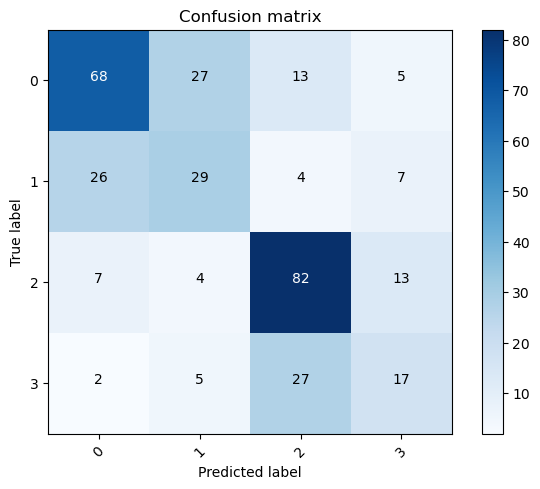

In [38]:
pred_2_classes = np.argmax(opt_model_2.predict(test_images), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_2_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Confusion matrix')
# plot_confusion_matrix.savefig('ConfusionMatrix.png')

In [ ]:
show_error_stats(errors_0, mispred_0, hard_mispred_0)

In [ ]:
show_error_stats(errors_1, mispred_1, hard_mispred_1)

In [ ]:
show_error_stats(errors_2, mispred_2, hard_mispred_2)

In [39]:
correct_0 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_0), test_labels)])
correct_1 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_1), test_labels)])
correct_2 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_2), test_labels)])

wrong_0 = np.logical_not(correct_0)
wrong_1 = np.logical_not(correct_1)
wrong_2 = np.logical_not(correct_2)

hard_wrong_0 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_0), test_labels)])
hard_wrong_1 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_1), test_labels)])
hard_wrong_2 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_2), test_labels)])

differ_0_1 = np.logical_xor(correct_0, correct_1)
differ_0_2 = np.logical_xor(correct_0, correct_2)
differ_1_2 = np.logical_xor(correct_1, correct_2)

wrong_all = np.logical_and(wrong_0, wrong_1, wrong_2)
hard_wrong_all = np.logical_and(hard_wrong_0, hard_wrong_1, hard_wrong_2)

print("Model 2 and 3 differ for %d samples" % np.sum(differ_0_1))
print("Model 2 and 5 differ for %d samples" % np.sum(differ_0_2))
print("Model 3 and 5 differ for %d samples" % np.sum(differ_1_2))

print("%d samples were misclassified by all three" % np.sum(wrong_all))
print("%d samples were hard misclassified by all three" % np.sum(hard_wrong_all))

Model 2 and 3 differ for 86 samples
Model 2 and 5 differ for 0 samples
Model 3 and 5 differ for 86 samples
227 samples were misclassified by all three
39 samples were hard misclassified by all three
